# 1. understanding frozenlake from gym documentation and implementing it.

Action size: 4
State size: 16


Runs: 100%|████████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.83s/it]


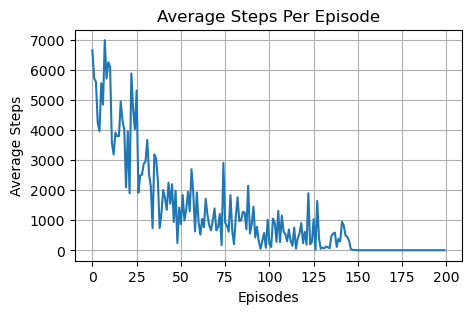

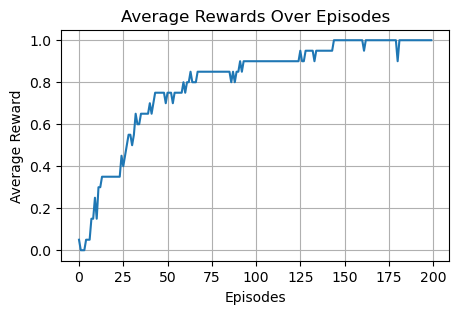

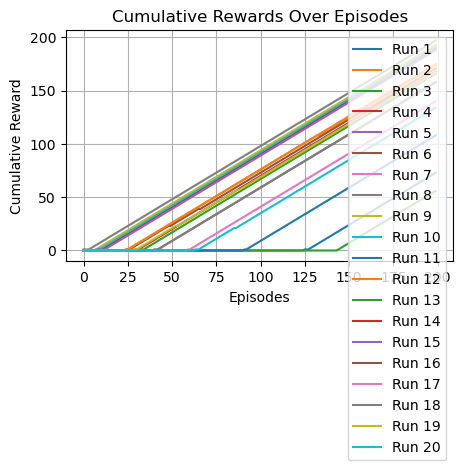

In [10]:
from pathlib import Path
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Define parameters
class Params(NamedTuple):
    total_episodes: int
    learning_rate: float
    gamma: float
    epsilon: float
    map_size: int
    seed: int
    is_slippery: bool
    n_runs: int
    action_size: int
    state_size: int
    proba_frozen: float

params = Params(
    total_episodes=200,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=4,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
)

# Set the seed
rng = np.random.default_rng(params.seed)

# Create FrozenLake environment
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

# Update params with action_size and state_size
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

# Q-learning class
class QLearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.qtable = np.zeros((state_size, action_size))

    def update_qtable(self, state, action, reward, new_state):
        """Update Q-table using Q-learning equation."""
        max_future_q = np.max(self.qtable[new_state, :])
        current_q = self.qtable[state, action]
        new_q = current_q + self.learning_rate * (reward + self.gamma * max_future_q - current_q)
        self.qtable[state, action] = new_q

# Epsilon-greedy class
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose action based on epsilon-greedy strategy."""
        if rng.uniform(0, 1) < self.epsilon:
            return action_space.sample()  # Exploration
        else:
            return np.argmax(qtable[state, :])  # Exploitation

# Run the environment
def run_env():
    learner = QLearning(params.learning_rate, params.gamma, params.state_size, params.action_size)
    explorer = EpsilonGreedy(params.epsilon)

    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps_data = np.zeros((params.total_episodes, params.n_runs))  # Track steps

    for run in tqdm(range(params.n_runs), desc="Runs"):
        learner.qtable = np.zeros((params.state_size, params.action_size))  # Reset Q-table

        for episode in range(params.total_episodes):
            state = env.reset(seed=params.seed)[0]
            total_rewards = 0
            steps = 0  # Track steps in each episode

            while True:
                action = explorer.choose_action(action_space=env.action_space, state=state, qtable=learner.qtable)
                new_state, reward, done, _, _ = env.step(action)
                learner.update_qtable(state, action, reward, new_state)
                total_rewards += reward
                steps += 1

                if done:
                    break

                state = new_state

            rewards[episode, run] = total_rewards
            steps_data[episode, run] = steps

    return rewards, steps_data

# Run the environment and get rewards and steps data
rewards_data, steps_data = run_env()

# Plot the average steps per episode
plt.figure(figsize=(5, 3))
plt.plot(steps_data.mean(axis=1))  # Plot the mean steps across episodes
plt.title('Average Steps Per Episode')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.grid(True)
plt.show()

# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(rewards_data.mean(axis=1))  # Plot the mean rewards across episodes
plt.title('Average Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


# Plot the results
plt.figure(figsize=(5, 3))
cumulative_rewards = np.cumsum(rewards_data, axis=0)
for run in range(params.n_runs):
    plt.plot(cumulative_rewards[:, run], label=f'Run {run + 1}')
plt.title('Cumulative Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating the performance for different hyperparameter values.

In [28]:
import gymnasium as gym
import numpy as np

def q_learning(env, num_episodes, alpha, gamma, epsilon):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    Q = np.zeros((num_states, num_actions))

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            step_res = env.step(action)
            next_state = step_res[0]
            reward = step_res[1]
            done = step_res[2]

            Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]))

            state = next_state

    return Q

def test_q_learning_policy(Q, env, epsilon=0.0, trials=1000):
    success = 0

    for _ in range(trials):
        state = env.reset()[0]
        done = False

        while not done:
            action = np.argmax(Q[state])

            step_res = env.step(action)
            state = step_res[0]
            done = step_res[2]

            if state == 15:  # Goal state
                success += 1

    success_rate = success / trials
    return success_rate

def main():
    env = gym.make("FrozenLake-v1")

    # Testing different values for alpha 
    alpha_values = [0.1, 0.3, 0.5]
    for alpha in alpha_values:
        Q = q_learning(env, num_episodes=5000, alpha=alpha, gamma=0.95, epsilon=0.2)
        success_rate = test_q_learning_policy(Q, env, epsilon=0.2, trials=1000)
        print(f"Success rate of Q-learning with alpha={alpha}: {success_rate * 100:.2f}%")

    # Testing different values for gamma 
    gamma_values = [0.90, 0.95, 0.99]
    for gamma in gamma_values:
        Q = q_learning(env, num_episodes=5000, alpha=0.1, gamma=gamma, epsilon=0.2)
        success_rate = test_q_learning_policy(Q, env, epsilon=0.2, trials=1000)
        print(f"Success rate of Q-learning with gamma={gamma}: {success_rate * 100:.2f}%")

    # Testing different values for epsilon 
    epsilon_values = [0.1, 0.3, 0.5]
    for epsilon in epsilon_values:
        Q = q_learning(env, num_episodes=5000, alpha=0.1, gamma=0.95, epsilon=epsilon)
        success_rate = test_q_learning_policy(Q, env, epsilon, trials=1000)
        print(f"Success rate of Q-learning with epsilon={epsilon}: {success_rate * 100:.2f}%")

if __name__ == "__main__":
    main()


Success rate of Q-learning with alpha=0.1: 78.30%
Success rate of Q-learning with alpha=0.3: 32.80%
Success rate of Q-learning with alpha=0.5: 6.60%
Success rate of Q-learning with gamma=0.9: 41.20%
Success rate of Q-learning with gamma=0.95: 62.30%
Success rate of Q-learning with gamma=0.99: 65.40%
Success rate of Q-learning with epsilon=0.1: 78.20%
Success rate of Q-learning with epsilon=0.3: 49.20%
Success rate of Q-learning with epsilon=0.5: 51.20%


# comparing performance of Policy iteration algorithm and Q-Learning.

In [30]:
import gymnasium as gym
import numpy as np

def evaluate_policy(policy, env, gamma=0.99, max_iterations=1000, tol=1e-6):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    V = np.zeros(num_states)

    for _ in range(max_iterations):
        delta = 0
        for s in range(num_states):
            v = V[s]
            V[s] = sum([p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][policy[s]]])
            delta = max(delta, abs(v - V[s]))

        if delta < tol:
            break

    return V

def improve_policy(V, env, gamma=0.99):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    policy_stable = True
    new_policy = np.zeros(num_states, dtype=int)

    for s in range(num_states):
        old_action = new_policy[s]
        action_values = np.zeros(num_actions)

        for a in range(num_actions):
            action_values[a] = sum([p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]])

        new_policy[s] = np.argmax(action_values)

        if old_action != new_policy[s]:
            policy_stable = False

    return new_policy, policy_stable

def policy_iteration(env, gamma=0.99, max_iterations=1000, tol=1e-6):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    policy = np.zeros(num_states, dtype=int)

    for i in range(max_iterations):
        V = evaluate_policy(policy, env, gamma, max_iterations, tol)
        new_policy, policy_stable = improve_policy(V, env, gamma)

        if policy_stable:
            print(f"Policy iteration converged at iteration {i + 1}.")
            break

        policy = new_policy

    return policy

def q_learning(env, num_episodes=5000, alpha=0.1, gamma=0.99, epsilon=0.2):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    Q = np.zeros((num_states, num_actions))

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            step_res = env.step(action)
            next_state = step_res[0]
            reward = step_res[1]
            done = step_res[2]

            Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]))

            state = next_state

    return Q

def test_q_learning_policy(Q, env, epsilon=0.2, trials=1000):
    success = 0

    for _ in range(trials):
        state = env.reset()[0]
        done = False

        while not done:
            action = np.argmax(Q[state])

            step_res = env.step(action)
            state = step_res[0]
            done = step_res[2]

            if state == 15:  # Goal state
                success += 1

    success_rate = success / trials
    return success_rate

def main():
    env = gym.make("FrozenLake-v1")
    optimal_policy = policy_iteration(env)
    print("Optimal Policy:")
    print(optimal_policy)

    success_rate = evaluate_policy(optimal_policy, env)
    print(f"Success rate of the optimal policy: {success_rate.mean() * 100:.2f}%")

    Q = q_learning(env, num_episodes=5000, epsilon=0.2)
    success_rate_q_learning = test_q_learning_policy(Q, env, epsilon=0.0, trials=1000)
    print(f"Success rate of Q-learning: {success_rate_q_learning * 100:.2f}%")

if __name__ == "__main__":
    main()


Optimal Policy:
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]
Success rate of the optimal policy: 39.62%
Success rate of Q-learning: 75.50%
